In [1]:
# remove mean of added noise per frame

In [2]:
import numpy as np, babelfish as bf, h5py, hdf5plugin, tables
from babelfish.helpers.nwb import NWB
import matplotlib.pyplot as plt, torch as T, torch.nn.functional as F
import tifffile, os

from pynwb.ophys import TwoPhotonSeries, OpticalChannel, ImageSegmentation, Fluorescence
from pynwb.device import Device
from pynwb.image import ImageSeries
import pynwb
from hdmf.backends.hdf5.h5_utils import H5DataIO

import scipy, cv2
from matplotlib.gridspec import GridSpec
import mpl_toolkits, matplotlib

from mpl_toolkits.axes_grid1 import AxesGrid

blosc filter already loaded, skip it.


In [3]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='2'

In [4]:
def cnmf_denoise_from_h5(cnmf_h5_path, W=512):
    cnmf_results = h5py.File(cnmf_h5_path, 'r')
    A_group = cnmf_results['/estimates/A']
    A = scipy.sparse.csc_matrix((A_group['data'], A_group['indices'], A_group['indptr']), shape=A_group['shape'])
    C = cnmf_results['/estimates/C']
    nFrames = C.shape[1]
    b = cnmf_results['/estimates/b']
    f = cnmf_results['/estimates/f']
    cnmf_denoised = A@C + b[: ]@f[:]
    # dynamically calculate height
    cnmf_denoised = np.moveaxis(np.moveaxis(cnmf_denoised.reshape(W,-1, nFrames),-1,0), -1,-2)
    return cnmf_denoised

In [5]:
# name = "f081318_3"
name = "f090418_2"
Z = 5
data_directory = f"/data/ritchie/{name}/"
# tyh5_path = f"{data_directory}{name}.ty.h5"
# tyh5 = tables.open_file(tyh5_path, 'r')
# first CNMF 
synthetic_cnmf_h5_path = data_directory + \
         "f090418_2_Z5_memmap__d1_399_d2_512_d3_1_order_C_frames_4000_.hdf5"
synthetic_imaging = cnmf_denoise_from_h5(synthetic_cnmf_h5_path, 512)
if not os.path.exists(data_directory+"imaging.tiff"):
    print("creating imaging from synthetic...")
    ValueError()
    # imaging = bf.helpers.resize_3d(caiman_vec_to_2D(denoised_plane_obs), 0.5, 0.5)
    imaging = bf.helpers.resize_3d(synthetic_imaging, 0.5, 0.5)

    imaging = bf.helpers.pad_imaging(imaging, 256, 256)

    imaging = imaging[:,None, None]
else:
    imaging = tifffile.imread(data_directory+"imaging.tiff")

In [6]:
raw_imaging = tifffile.imread(f"/data/ritchie/{name}/f090418_2_Z{Z}.tif")

In [7]:
def caiman_vec_to_2D(x, nFrames,W):
    "Reshape caiman vector into an image"
    return np.transpose(x.reshape(W,-1, nFrames))

#works but don't know how to get background
io = pynwb.NWBHDF5IO(data_directory+"f090418_2_Z5.nwb", 'r')
nwbfile = io.read()

nwbfile.processing['ophys']
cnmf_results = nwbfile.processing['ophys'].data_interfaces

planeseg = cnmf_results['ImageSegmentation'].plane_segmentations['PlaneSegmentation']

[(c,planeseg[c].shape) for c in planeseg.colnames]

cnmf_results['ImageSegmentation'].plane_segmentations['PlaneSegmentation']['image_mask'].shape

In [8]:
def sample_like(noisy_patch, imaging):
    "Sample from empirical noise."
    new_imaging = np.zeros_like(imaging)
    T = imaging.shape[0]
    H,W = (imaging.shape[-2],imaging.shape[-1])
    shap = imaging.shape[1:]
    for t in range(T):
        new_imaging[t] = imaging[t] + np.random.choice(noisy_patch[t].reshape(-1), shap)
    return new_imaging.astype(np.float32)

try:
    tiffpath = f"/data/ritchie/{name}/real_noise_{Z}_imaging.tiff"
    real_noise_imaging = tifffile.imread(tiffpath)
except:
    print("real_noise_imaging")
    raise ValueError()
    real_noise_imaging = sample_like(raw_imaging[:,320:,:80]-raw_imaging[:,320:,:80].mean(2).mean(1)[:,None,None], synthetic_imaging)
    real_noise_imaging = bf.helpers.resize_3d(real_noise_imaging, 0.5, 0.5)
    real_noise_imaging = bf.helpers.pad_imaging(real_noise_imaging, 256, 256)
    tifffile.imsave(tiffpath, real_noise_imaging)
real_noise_imaging = real_noise_imaging[:,None,None]

In [9]:
raw_imaging[:,320:,:80].mean(2).mean(1)

array([77.290344, 78.12864 , 77.75965 , ..., 72.62707 , 73.86029 ,
       72.86789 ], dtype=float32)

Text(0.5, 1.0, 'Distribution of noise pixel values')

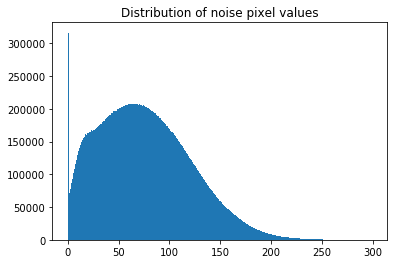

In [10]:
plt.hist(raw_imaging[:,320:,:80].reshape(-1),bins=np.arange(300))
# plt.ylim(0,100000)
# plt.yscale('log')
plt.title("Distribution of noise pixel values")
# plt.xlim(0,100)

In [11]:
noise_dist = T.from_numpy(raw_imaging[:,320:,:80].reshape(-1))
nNoise = len(noise_dist)

(2400, 2500)

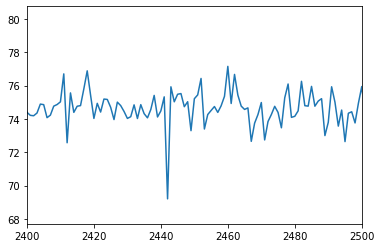

In [12]:
plt.plot(raw_imaging[:,320:,:80].reshape(raw_imaging.shape[0],-1).mean(1))
plt.xlim(2400,2500)

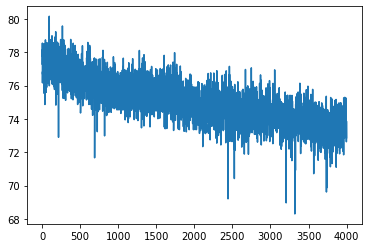

In [13]:
plt.plot(raw_imaging[:,320:,:80].reshape(raw_imaging.shape[0],-1).mean(1))

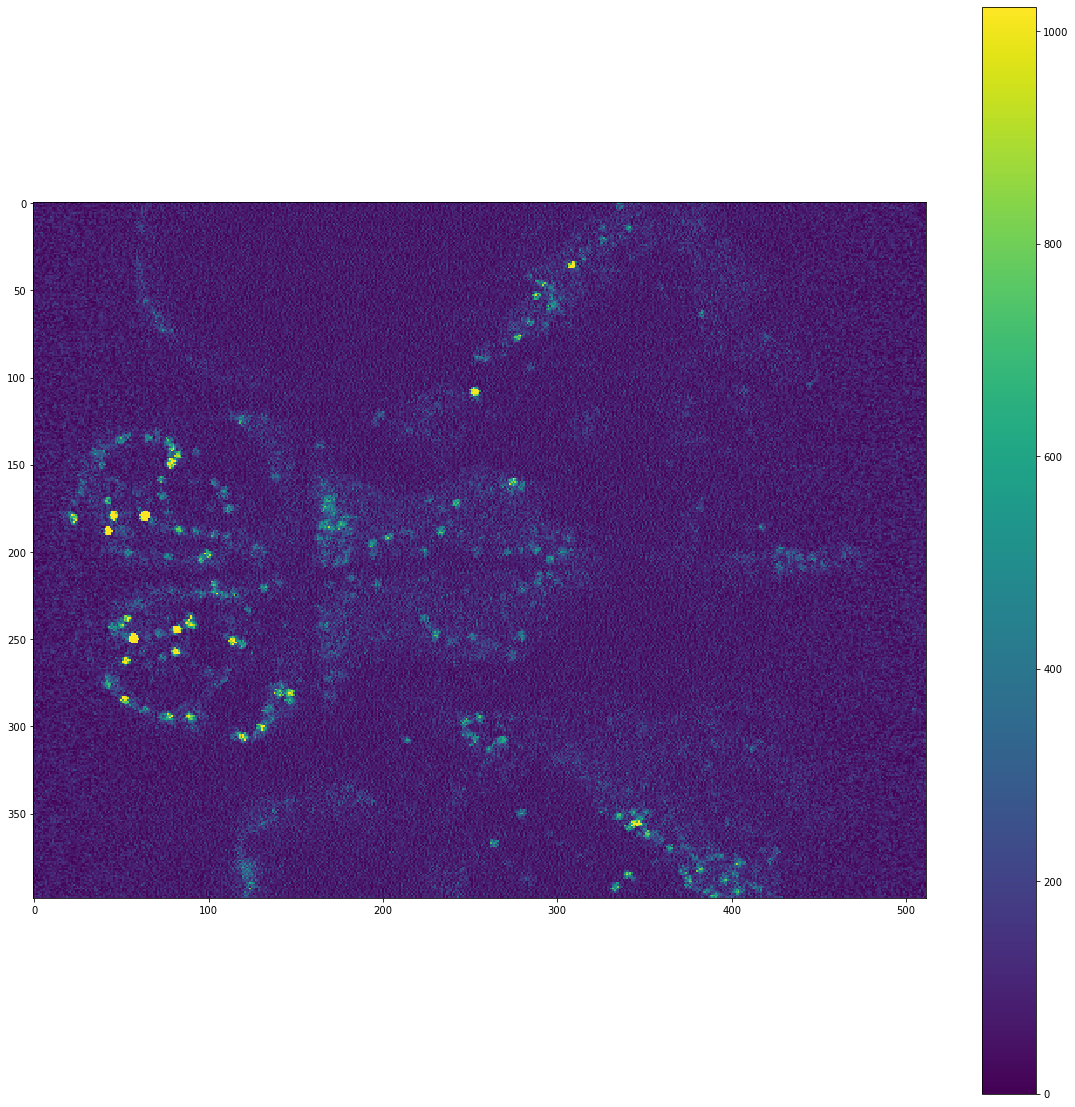

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(raw_imaging[100])
plt.colorbar()

ti = T.from_numpy(imaging[1000,0,0]).cuda()
p_sample = T.distributions.poisson.Poisson(ti).sample() + noise_dist[T.randint(0,nNoise,(ti.shape))].cuda()

plt.figure(figsize=(15,15))
plt.imshow(p_sample.cpu().numpy())
# plt.colorbar()

In [15]:
from babelfish_models.models.deep_skip import DeepSkip, train
from babelfish.helpers import train_test_split
from babelfish.data import ZebraFishData
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn, mlflow, os, datetime

Model = DeepSkip
cuda = True
gpus = [0,1]

In [16]:
class NewNoiseData(Dataset):
    """Add noise to each training example.
    
    B x nFrames x Z x H x W"""
    def __init__(self, imaging, auxiliary={}, index_map=None, prev_frames=2, next_frames=1,
                 dtype=np.float32, variance=1.):
        # use channel for future / prev frames
        self.data = imaging
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.auxiliary = auxiliary
        self.aux_vars = list(auxiliary.keys())
        self.index_map = index_map
        self.dtype = dtype

    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        "X[0]==X_i, X[1]==X_i-1, Y[0]==Y_i+1, Y[1]==Y_i+2"
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i + self.prev_frames - 1 # avoid wraparound
        aux = {k: [] for k in self.auxiliary.keys()}
        X = {"brain": []}
        X.update(aux)
        Y = {"brain": []}
        Y.update(aux)
        for i in reversed(range(self.prev_frames)):
            ix = idx-i
            datum = T.tensor(self.data[ix].astype(self.dtype))
            datum += variance**0.5*T.randn_like(datum)
            X["brain"].append(datum)
            for k,v in self.auxiliary.items():
                X[k].append(v[ix])
        for i in range(1,self.next_frames+1):
            ix = idx+i
            datum = T.tensor(self.data[ix].astype(self.dtype))
            Y["brain"].append(datum)
            for k,v in self.auxiliary.items():
                Y[k].append(v[ix])
        X = {k: T.stack(v,0) for k,v in X.items()}
        Y = {k: T.stack(v,0) for k,v in Y.items()}
        return X, Y

    
variance=1000
next_frames = 5
prev_frames = 10
n_epochs = 10
n_embedding = 2
sparse_lambda = 1e-3
batch_size = 64
kl_lambda = 5e-4
lr = 1e-1
num_workers = 8
multi_gpu = True
seed = 24
half = False
    
    
nFrames, nC, nZ, H, W = imaging.shape
# don't use chunking so kalman filter works properly
last_index_for_test = nFrames-next_frames # minus 1 for exclusive range
first_index_for_test = last_index_for_test-200
first_index_for_train = prev_frames-1
last_index_for_train = first_index_for_test - prev_frames - next_frames
print(f"train: {first_index_for_train}:{last_index_for_train}\ntest: {first_index_for_test}:{last_index_for_test}")
tvt_split = {"train": list(np.arange(first_index_for_train, last_index_for_train)),
             "test": list(np.arange(first_index_for_test, last_index_for_test)),
             "validation": []}
# tvt_split = train_test_split(nFrames, nchunks=20, next_frames=next_frames, prev_frames=prev_frames)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])

train: 9:3780
test: 3795:3995
['train: 3771 (94.96%)', 'test: 200 (5.04%)', 'validation: 0 (0.00%)']


In [17]:
try:
    tiffpath = f"/data/ritchie/{name}/small_decon_{Z}_gauss_{variance}.tiff"
    noisy_imaging = tifffile.imread(tiffpath)
except:
    print("creating noisy_imaging")
    raise ValueError()
    noisy_imaging = (T.from_numpy(imaging) + variance**0.5*T.randn(*imaging.shape)).numpy()
    tifffile.imsave(f"/data/ritchie/{name}/small_decon_{Z}_gauss_{variance}.tiff", noisy_imaging)
    tifffile.imsave(f"/data/ritchie/{name}/imaging.tiff", imaging)

In [18]:
train_data = ZebraFishData(real_noise_imaging, {},
                tvt_split['train'], prev_frames,next_frames)
test_data = ZebraFishData(real_noise_imaging, {},
                tvt_split['test'], prev_frames,next_frames)

In [19]:
real_noise_imaging.shape

(4000, 1, 1, 256, 256)

train_data_variable_noise = NewNoiseData(noisy_imaging, {},
                tvt_split['train'], prev_frames,next_frames, variance=variance)
test_data_variable_noise = NewNoiseData(noisy_imaging, {},
                tvt_split['test'], prev_frames,next_frames, variance=variance)

# create NWB from synthetic
import re

month_day_year = re.compile(r"(\d\d)"*3)
m = month_day_year.match(name[1:7])
month, day, year = m.groups()
year = "20"+year
start_time = f"{year}-{month}-{day}"

frame_rate = 1/np.diff(tyh5.root.imaging.frame_start[:,0]).mean()
frame_rate

filepath = f"/data/ritchie/{name}/small_decon_{Z}_gauss_{variance}.nwb"
if not os.path.exists(filepath):
    # create NWB
    nwb = NWB()
    session_description = "synthetic + gaussian noise"
    session_identifier=name
    experimenter="Ritchie/Tyler"
    lab="d-lab"
    institution="Stanford"
    nwb.new(filepath, start_time, session_description,
                session_identifier, experimenter,
                institution, lab)

    two_p = True
    z_um = np.nan; x_um =  1.; y_um= 1.
    # grid_spacing = [z_um, y_um, x_um]
    #     def add_array(self,  frame_rate:float, array,
    #             name:str="imaging", two_p:bool=False, compression_level=3,
    #             indicator:str='', ochannel_desc:str='', plane_description:str='',
    #             excitation:float=np.nan, emission:float=np.nan, device:str='',
    #             x_um:float=np.nan, y_um:float=np.nan, z_um:float=np.nan,
    #             channel:int=None):

    nwb.add_array(frame_rate, noisy_imaging[:,0], "noisy_imaging",
                  two_p, z_um=z_um, y_um=y_um, x_um=x_um, device="unknown-device")

    nwb.close()

In [20]:
stop

NameError: name 'stop' is not defined

In [402]:
mlflow.pytorch.log_model(conv_model, "models")
mlflow.end_run()

In [21]:
LOG = False
EXPERIMENT_NAME = "denoise"
mlflow.set_experiment(EXPERIMENT_NAME)

from babelfish_models.models.deep_skip import DeepSkip as Model
model = "deepskip"
tensor = T.cuda.FloatTensor
print("create model")
conv_model = Model(nC,nZ,H,W,n_embedding,prev_frames,next_frames, tensor=tensor)
conv_model.cuda()
if multi_gpu:
    conv_model = nn.DataParallel(conv_model, device_ids=gpus)

# log params
nParams = np.sum([np.prod(x.shape) for x in conv_model.parameters()])
if LOG:
    mlflow.start_run()


# TODO make automatic, perhaps by using mlflow run
    mlflow.log_params({
        "nParams": nParams,
        "data_path": tiffpath,
        "model": model,
        "notes": "synthetic caiman reconstruction (tyler cnmf) + real noise (from patch, time-varying) = noisy imaging",
        "prev_frames": prev_frames,
        "next_frames": next_frames,
        "kl_lambda": kl_lambda,
        "sparse_lambda": sparse_lambda,
        "lr": lr,
        "n_epochs": n_epochs,
        "n_embedding": n_embedding,
        "batch_size": batch_size,
        "multi_gpu": multi_gpu,
        "gpus": gpus,
        "seed": seed
    })
print("total num params:", nParams)

avg_Y_loss, avg_Y_valid_loss = train(conv_model,train_data,test_data,n_epochs,lr=lr, kl_lambda=1e-3, half=half,
                                     cuda=cuda, batch_size=batch_size, num_workers=num_workers, log=LOG)

now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

if LOG:
    mlflow.pytorch.log_model(conv_model, "models")
    mlflow.end_run()

create model


  0%|          | 0/59 [00:00<?, ?it/s]

total num params: 1279998
epoch 0: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 5.411415E+01, X_loss: 2.698705E+01, Y_loss: 2.712706E+01, KLD: 5.048558E+00


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 4.663802E+01, X_loss: 2.302308E+01, Y_loss: 2.361295E+01, KLD: 1.994076E+00
epoch 1: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 3.089809E+01, X_loss: 1.531540E+01, Y_loss: 1.558268E+01, KLD: 5.931895E-01


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 4.646614E+01, X_loss: 2.263955E+01, Y_loss: 2.382622E+01, KLD: 3.661435E-01
epoch 2: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.991543E+01, X_loss: 9.732854E+00, Y_loss: 1.018257E+01, KLD: 9.166945E-02


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 2.271291E+01, X_loss: 1.081113E+01, Y_loss: 1.190177E+01, KLD: 1.004100E-02
epoch 3: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.675458E+01, X_loss: 8.124392E+00, Y_loss: 8.630183E+00, KLD: 1.663591E-03


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 2.383301E+01, X_loss: 9.329050E+00, Y_loss: 1.450396E+01, KLD: 8.739322E-05
epoch 4: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.528280E+01, X_loss: 7.373123E+00, Y_loss: 7.909673E+00, KLD: 1.077882E-04


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 2.001919E+01, X_loss: 9.455652E+00, Y_loss: 1.056353E+01, KLD: 1.976624E-05
epoch 5: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.461380E+01, X_loss: 7.033512E+00, Y_loss: 7.580291E+00, KLD: 1.698629E-05


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 1.850409E+01, X_loss: 8.670541E+00, Y_loss: 9.833553E+00, KLD: 2.209097E-05
epoch 6: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.437556E+01, X_loss: 6.911472E+00, Y_loss: 7.464088E+00, KLD: 7.014136E-06


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 1.831919E+01, X_loss: 8.552207E+00, Y_loss: 9.766982E+00, KLD: 6.024987E-06
epoch 7: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.424358E+01, X_loss: 6.844869E+00, Y_loss: 7.398707E+00, KLD: 4.215942E-06


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 1.828504E+01, X_loss: 8.549853E+00, Y_loss: 9.735188E+00, KLD: 3.110319E-06
epoch 8: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.418940E+01, X_loss: 6.816729E+00, Y_loss: 7.372675E+00, KLD: 2.507228E-06


  0%|          | 0/59 [00:00<?, ?it/s]

VALIDATION: avg_loss: 1.843748E+01, X_loss: 8.569637E+00, Y_loss: 9.867844E+00, KLD: 2.339929E-06
epoch 9: 

  0%|          | 0/4 [00:00<?, ?it/s]

avg_loss: 1.411676E+01, X_loss: 6.780578E+00, Y_loss: 7.336179E+00, KLD: 1.817871E-06


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

VALIDATION: avg_loss: 1.823982E+01, X_loss: 8.542264E+00, Y_loss: 9.697560E+00, KLD: 8.035898E-06


2.28e+01
1.654e+01
5 prev, 5e-2 lr, avg_loss: 3.371456E+01, X_loss: 1.657291E+01, Y_loss: 1.714165E+01, KLD: 1.869881E-02
10 prev avg_loss: 3.312751E+01, X_loss: 1.628646E+01, Y_loss: 1.684105E+01, KLD: 2.071375E-04

In [22]:
# kalman = tifffile.imread(f"/data/ritchie/{name}/small_decon_{Z}_gauss_{variance}_kalman.tiff")
kalman = tifffile.imread(f"/data/ritchie/{name}/real_noise_{5}_imaging_kalman.tif")

In [23]:
cnmf_denoised = cnmf_denoise_from_h5(data_directory +
     "small_decon_5_gauss_1000_memmap__d1_256_d2_256_d3_1_order_C_frames_4000_.hdf5",W=256)[:,None,None]

cnmf_nonoise = cnmf_denoise_from_h5(data_directory +
     "imaging_memmap__d1_256_d2_256_d3_1_order_C_frames_4000_.hdf5",W=256)[:,None,None]


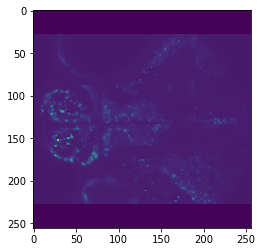

In [24]:
plt.imshow(cnmf_denoised[0,0,0])

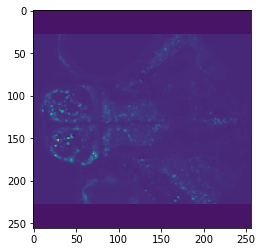

In [26]:
plt.imshow(cnmf_nonoise[0,0,0])

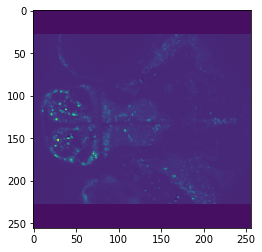

In [27]:
plt.imshow(imaging[0,0,0])

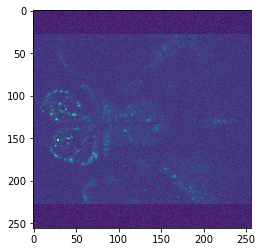

In [28]:
plt.imshow(noisy_imaging[0,0,0])

plt.imshow(cnmf_nonoise[0,0,0])

In [25]:
import babelfish_models as bfm

use_test = True
use_test = False
if use_test:
    dset_data = test_data
    first_index = first_index_for_test
    n_samples = len(test_data)
else:
    dset_data = train_data
    first_index = first_index_for_train
    n_samples = len(train_data)
    

In [26]:
with T.no_grad():
    for b, batch in enumerate(DataLoader(dset_data, batch_size=1, shuffle=False, pin_memory=True)):
        X, Y = batch
        # TODO refactor for generic auxiliary vars
        X = X["brain"]
        Y = Y["brain"]
        output = conv_model(X)
        X_pred = output["prev"]
        Y_pred = output["pred"]
        X_pred = X_pred.cpu().numpy()[0,0,0]
        Y_pred = Y_pred.cpu().numpy()[0,0,0]
        X = X.cpu().numpy()[-1,0,0,0]
        break

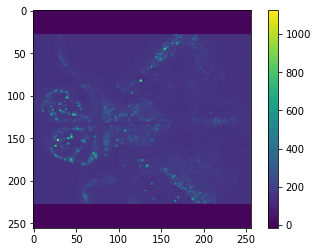

In [115]:
plt.imshow(X_pred)
plt.colorbar()

In [27]:
cnmf_results = h5py.File(synthetic_cnmf_h5_path, 'r')
A_group = cnmf_results['/estimates/A']
A = scipy.sparse.csc_matrix((A_group['data'], A_group['indices'], A_group['indptr']), shape=A_group['shape'])
C = cnmf_results['/estimates/C']
nFrames = C.shape[1]
b = cnmf_results['/estimates/b']
f = cnmf_results['/estimates/f']
# cnmf_denoised = A@C + b[: ]@f[:]
# dynamically calculate height
# cnmf_denoised = np.moveaxis(np.moveaxis(cnmf_denoised.reshape(W,-1, nFrames),-1,0), -1,-2)


In [31]:
std_neurons = np.std(C,axis=1)

In [32]:
most_active_indices = np.argsort(std_neurons)[:-6:-1]
most_active_masks = caiman_vec_to_2D(A.toarray()[:,most_active_indices],5,512)
most_active_masks = bf.helpers.resize_3d(most_active_masks,0.5,0.5)
# most_active_mask = cv2.resize((most_active_mask), None, fx=0.5, fy=0.5,
#                                  interpolation=cv2.INTER_LINEAR)
most_active_masks = bf.helpers.pad_imaging(most_active_masks,256,256)

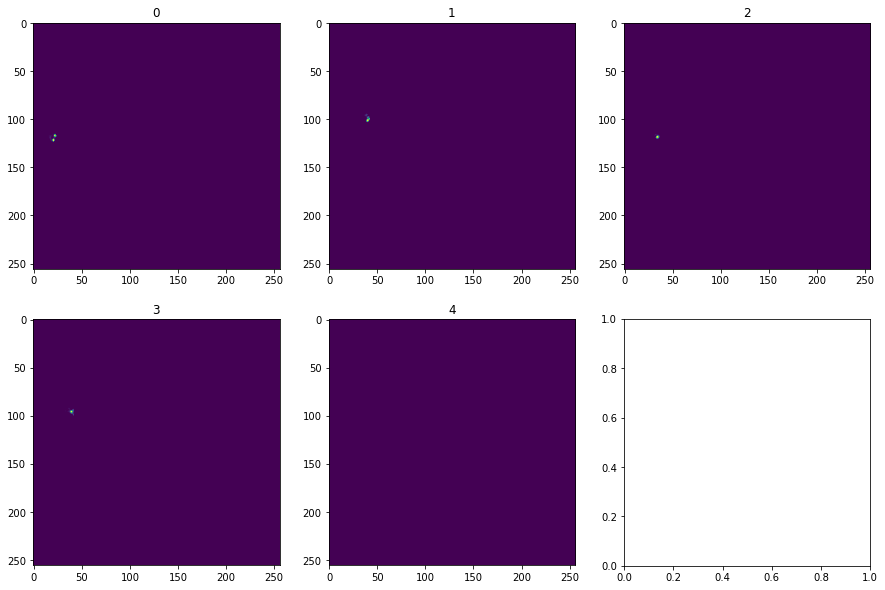

In [33]:
fig, axs = plt.subplots(2,3, figsize=(15,10))
for i,ax in enumerate(axs.reshape(-1)[:-1]):
    ax.imshow(most_active_masks[i])
    ax.set_title(i)

In [34]:
most_active_idx = most_active_indices[3]
most_active_mask = most_active_masks[3]

Text(0.5, 1.0, 'Distribution of synthetic pixel values')

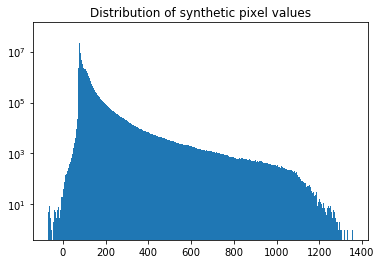

In [35]:
plt.hist(imaging.reshape(-1),bins=1000)
# plt.ylim(0,100000)
plt.yscale('log')
plt.title("Distribution of synthetic pixel values")

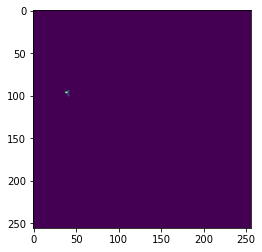

In [126]:
plt.imshow(most_active_mask)

In [281]:
most_active_mask_cu.shape

torch.Size([256, 256])

In [36]:
# 0: no denoise, 1: kalman, 2: CaImAn denoised, 3: caiman no noise, 4: VP
nModels = 5
sum_mse = np.zeros([n_samples,nModels])
sanity = np.zeros([n_samples,2,256,256])
mse_per_pixel = np.zeros([n_samples, nModels, 256, 256])
actual_most_active_neuron = np.zeros([n_samples])
most_active_neuron = np.zeros([n_samples, nModels])
most_active_mask_cu = T.from_numpy(most_active_mask).cuda()
with T.no_grad():
    for b, batch in enumerate(DataLoader(dset_data, batch_size=1, shuffle=False, pin_memory=True)):
        X, Y = batch
        # TODO refactor for generic auxiliary vars
        X = X["brain"]
        Y = Y["brain"]
        index_offset = first_index+b+1
        Y_noiseless = T.from_numpy(imaging[index_offset])
        assert Y.shape[2:]==T.Size([1, 1, 256, 256])
        assert Y_noiseless.shape==T.Size([1, 1, 256, 256])
        if cuda:
            # TODO data.to('cuda:0', non_blocking=True) or similar
            Y = Y.cuda()[0,0,0,0]
            Y_noiseless = Y_noiseless[0,0].cuda()
        output = conv_model(X)
        m4_pred = output["prev"] # n+1, "next" is n+5
        
        actual_most_active_neuron[b] = T.sum(most_active_mask_cu * Y_noiseless)
        
        m0_mse = F.mse_loss(Y_noiseless, Y, reduce=False)
        mse_per_pixel[b,0] += m0_mse.cpu().numpy()
        sum_mse[b,0] = T.sum(m0_mse).cpu().numpy()
        most_active_neuron[b,0] = T.sum(most_active_mask_cu * Y)

        m1_pred = T.from_numpy(kalman[index_offset]).cuda()
        m1_mse = F.mse_loss(Y_noiseless, m1_pred, reduce=False)
        mse_per_pixel[b,1] += m1_mse.cpu().numpy()
        sum_mse[b,1] = T.sum(m1_mse).cpu().numpy()
        most_active_neuron[b,1] = T.sum(most_active_mask_cu * m1_pred)

        # CaImAn on noise
        m2_pred = T.from_numpy(cnmf_denoised[index_offset].astype(np.float32)).cuda()
        m2_mse = F.mse_loss(Y_noiseless, m2_pred, reduce=False)
        mse_per_pixel[b,2] += m2_mse.cpu().numpy()[0,0]
        sum_mse[b,2] = T.sum(m2_mse).cpu().numpy()
        most_active_neuron[b,2] = T.sum(most_active_mask_cu * m2_pred)

        # CaImAn no noise
        m3_pred = T.from_numpy(cnmf_nonoise[index_offset].astype(np.float32)).cuda()
        m3_mse = F.mse_loss(Y_noiseless, m3_pred, reduce=False)
        mse_per_pixel[b,3] += m3_mse.cpu().numpy()[0,0]
        sum_mse[b,3] = T.sum(m3_mse).cpu().numpy()
        most_active_neuron[b,3] = T.sum(most_active_mask_cu * m3_pred)
 
        # VP
        m4_mse = F.mse_loss(Y_noiseless, m4_pred, reduce=False)
        mse_per_pixel[b,4] += m4_mse.cpu().numpy()[0,0,0]
        sum_mse[b,4] = T.sum(m4_mse).cpu().numpy()
        most_active_neuron[b,4] = T.sum(most_active_mask_cu * m4_pred)

        sanity[b,0] = Y.cpu()
        sanity[b,1] = real_noise_imaging[index_offset,0,0]

/nix/store/gdc4q9wc72s6q8a2zxq74hyq5pcqdfkv-python3-3.7.5-env/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/nix/store/gdc4q9wc72s6q8a2zxq74hyq5pcqdfkv-python3-3.7.5-env/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/nix/store/gdc4q9wc72s6q8a2zxq74hyq5pcqdfkv-python3-3.7.5-env/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Using a target size (torch.Size([1, 1, 256, 256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/nix/store/gdc4q9wc72s6q8a2zxq74hyq5pcqdfkv-python3-3.7.5

In [131]:
assert np.sum(sanity[:,0]!=sanity[:,1])==0

In [38]:
model_names = ["noisy", "Kalman", "CaImAn", "CaImAn (no noise)", "VP"]

In [133]:
most_active_idx

695

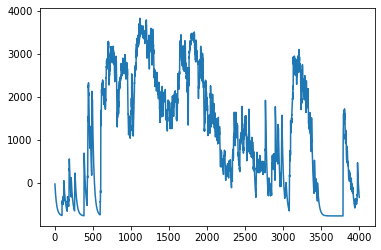

In [134]:
plt.plot(C[most_active_idx])

In [135]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.plot(np.hstack([actual_most_active_neuron[:,None], most_active_neuron[:,[0]]]))
plt.legend(["actual"] + model_names)

NameError: name 'matplotlib' is not defined

In [136]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.plot(np.hstack([actual_most_active_neuron[:,None], most_active_neuron[:,[1]]]))
plt.legend(["actual"] + model_names)

NameError: name 'matplotlib' is not defined

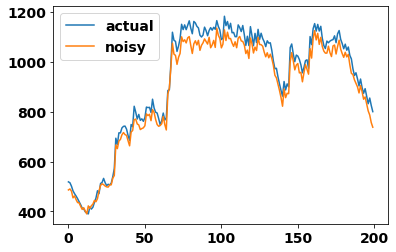

In [312]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.plot(np.hstack([actual_most_active_neuron[:,None], most_active_neuron[:,[2]]]))
plt.legend(["actual"] + model_names)

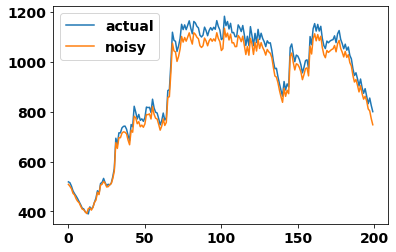

In [313]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.plot(np.hstack([actual_most_active_neuron[:,None], most_active_neuron[:,[3]]]))
plt.legend(["actual"] + model_names)

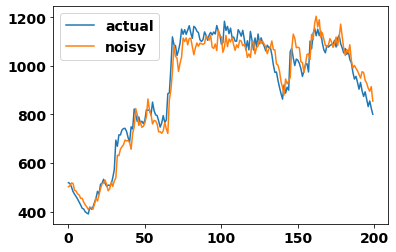

In [314]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.plot(np.hstack([actual_most_active_neuron[:,None], most_active_neuron[:,[4]]]))
plt.legend(["actual"] + model_names)

In [316]:
imaging.shape

(4000, 1, 1, 256, 256)

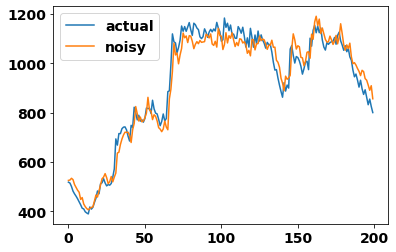

In [289]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
plt.plot(np.hstack([actual_most_active_neuron[:,None], most_active_neuron[:,[4]]]))
plt.legend(["actual"] + model_names)

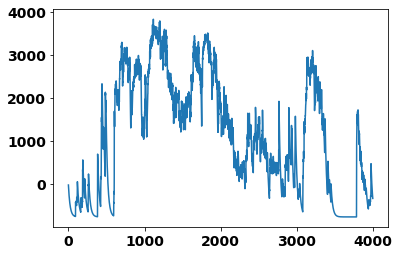

In [290]:
plt.plot(C[most_active_idx])

Text(0.5, 0.98, 'MSE per pixel')

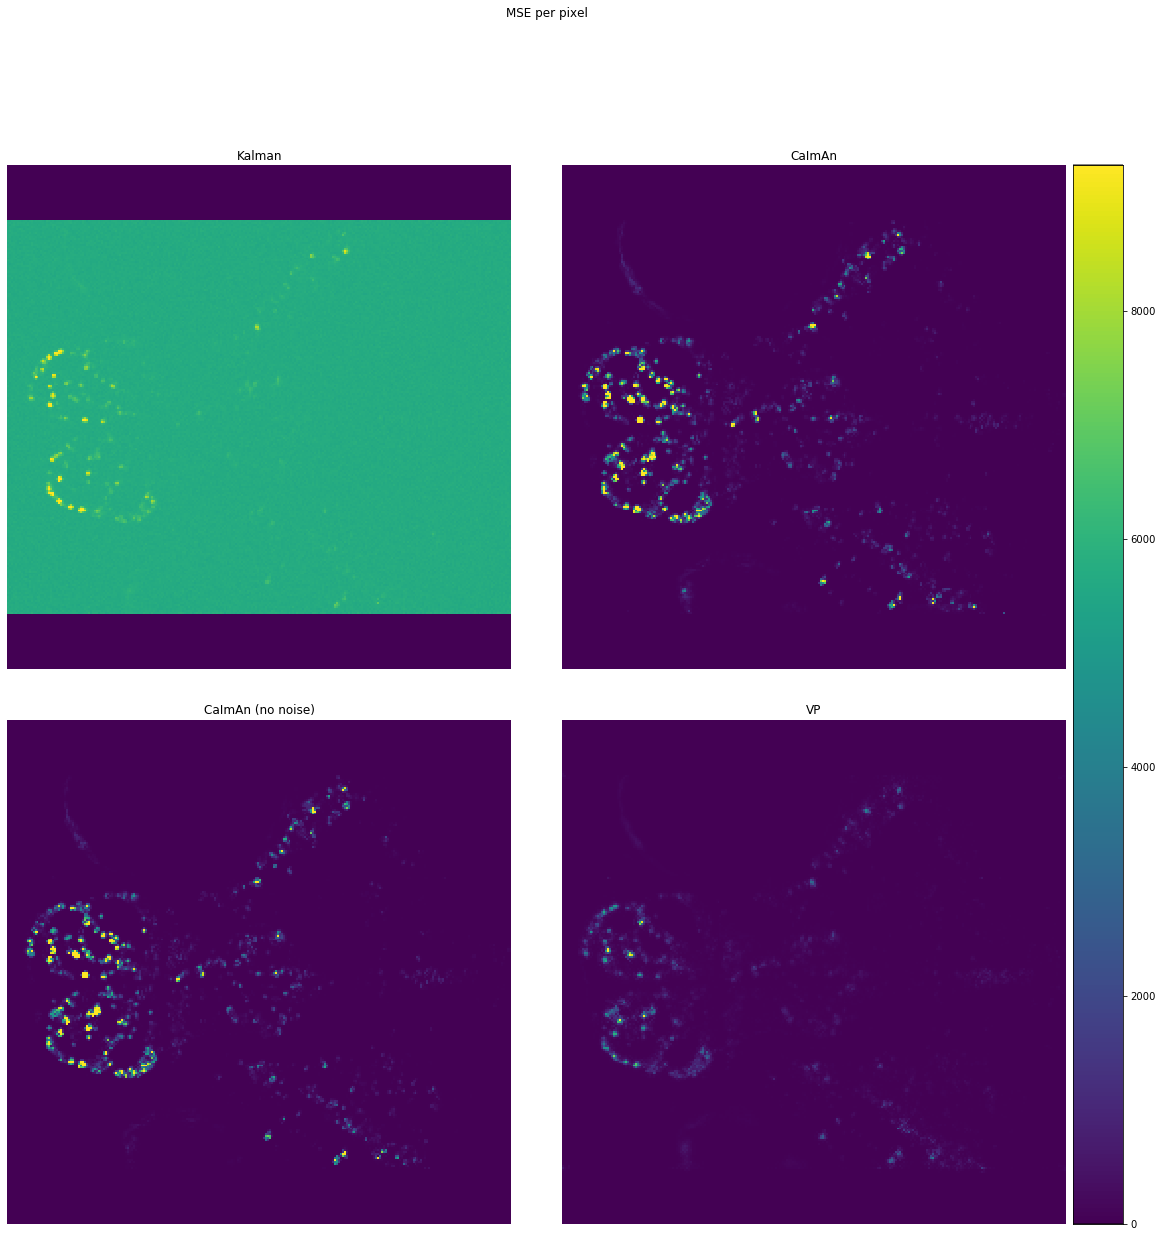

In [44]:
mean_mse_px = np.mean(mse_per_pixel,axis=0)
vmin = np.percentile(mean_mse_px,0.1)
vmax = np.percentile(mean_mse_px,99.9)
# fig, axs = plt.subplots(2,2, figsize=(20,20))
fig = plt.figure(figsize=(20,20))
grid = mpl_toolkits.axes_grid1.AxesGrid(fig, 111,
                nrows_ncols=(2, 2),
                axes_pad=0.7,
                cbar_mode='single',
                cbar_location='right',
                cbar_pad=0.1
                )

for i,ax in enumerate(grid):
    im = ax.imshow(mean_mse_px[i+1],vmin=vmin,vmax=vmax)
    ax.set_title(model_names[i+1])
    ax.set_axis_off()
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)
fig.suptitle("MSE per pixel")
# plt.colorbar()

Text(0.5, 1.0, 'VP minus Kalman pixelwise abs(E)')

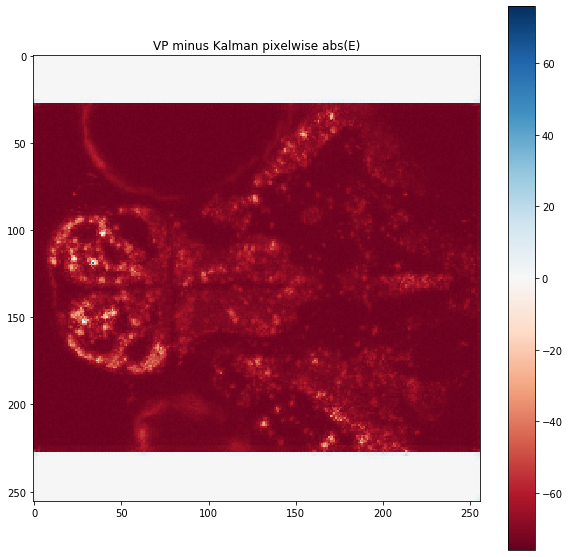

In [40]:
diff = np.sqrt(mean_mse_px[4])-np.sqrt(mean_mse_px[1])
vmax = np.percentile(np.abs([np.max(diff), np.min(diff)]), 99)
# vmax=
plt.figure(figsize=(10,10))
plt.imshow(diff, cmap="RdBu",vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title("VP minus Kalman pixelwise abs(E)")

Text(0.5, 1.0, 'VP minus CaImAn pixelwise abs(E)')

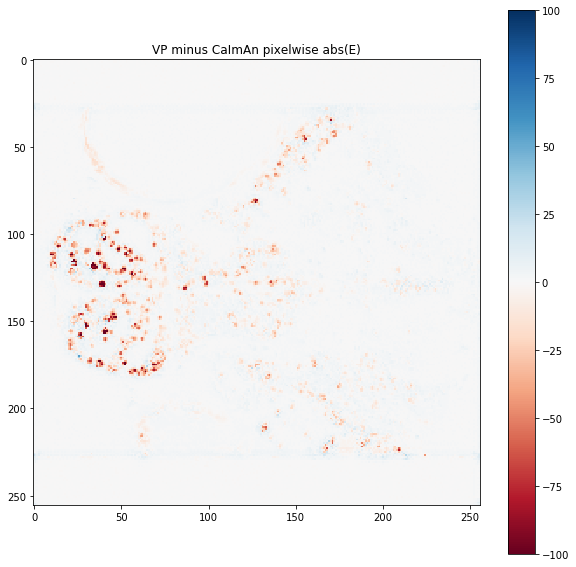

In [41]:
diff = np.sqrt(mean_mse_px[4])-np.sqrt(mean_mse_px[2])
vmax = np.percentile(np.abs([np.max(diff), np.min(diff)]), 99)
vmax=100
plt.figure(figsize=(10,10))
plt.imshow(diff, cmap="RdBu",vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title("VP minus CaImAn pixelwise abs(E)")

Text(0.5, 1.0, 'CaImAn minus Kalman pixelwise abs(E)')

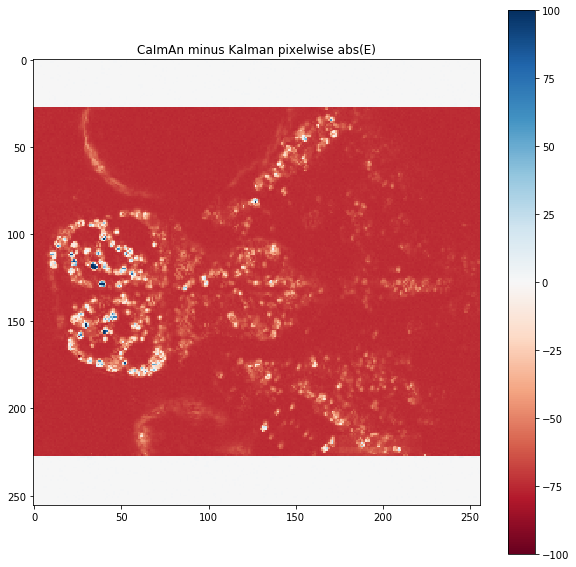

In [45]:
diff = np.sqrt(mean_mse_px[2])-np.sqrt(mean_mse_px[1])
vmax = np.percentile(np.abs([np.max(diff), np.min(diff)]), 99)
vmax=100
plt.figure(figsize=(10,10))
plt.imshow(diff, cmap="RdBu",vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title("CaImAn minus Kalman pixelwise abs(E)")

In [42]:
# vmax=3000
plt.figure(figsize=(10,10))
plt.imshow(), cmap="RdBu",vmax=vmax, vmin=-vmax)
plt.colorbar()
plt.title("VP minus CaImAn pixelwise MSE")

SyntaxError: invalid syntax (<ipython-input-42-4f712bd53bcd>, line 3)

In [151]:
std_image = np.std(imaging,axis=0)

In [154]:
std_image.shape

(1, 1, 256, 256)

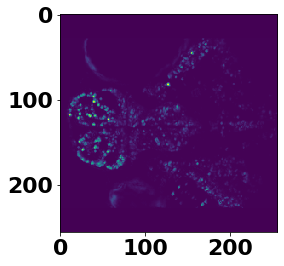

In [155]:
plt.imshow(std_image[0,0])

Text(0.5, 1.0, 'Test set MSE vs ground truth')

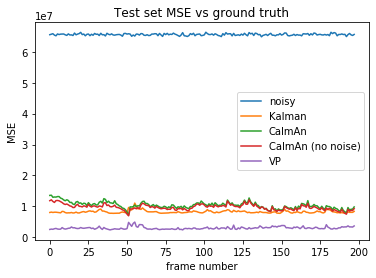

In [88]:
plt.plot(result[:n_samples-2,0])
plt.plot(result[:n_samples-2,1])
plt.plot(result[:n_samples-2,2])
plt.plot(result[:n_samples-2,3])
plt.plot(result[:n_samples-2,4])
plt.legend(model_names)
# plt.legend(["noisy", "Kalman", "CaImAn", "VP"])
plt.xlabel("frame number")
plt.ylabel("MSE")
# TODO why a noise spike??
if use_test:
    tit = "Test"
else:
    tit = "Train"
plt.title(f"{tit} set MSE vs ground truth")

Text(0.5, 1.0, 'Test set MSE vs ground truth')

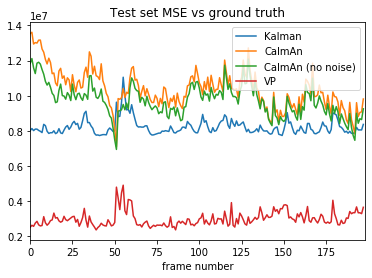

In [89]:
# plt.plot(result[:,0])
plt.xlim(0,n_samples-2)
plt.plot(result[:n_samples-2,1])
plt.plot(result[:n_samples-2,2])
plt.plot(result[:n_samples-2,3])
plt.plot(result[:n_samples-2,4])
# TODO why a noise spike??
plt.xlim(0,n_samples-2)
# plt.ylim(5e5,2e6)
# plt.legend(["Kalman", "CaImAn", "VP"])
plt.legend(["Kalman", "CaImAn", "CaImAn (no noise)", "VP"])
plt.xlabel("frame number")
if use_test:
    tit = "Test"
else:
    tit = "Train"
plt.title(f"{tit} set MSE vs ground truth")

In [68]:
print("VP %noise of Kalman")
result[:,4].mean()/(result[:,1].mean())*100

VP %noise of Kalman


36.516379138924506

In [69]:
print("VP %noise of CaImAn")
result[:,4].mean()/(result[:,2].mean())*100

VP %noise of CaImAn


28.9925537955391

In [70]:
print("VP %noise of noisy imaging")
result[:,4].mean()/(result[:,0].mean())*100

VP %noise of noisy imaging


4.577952909757237

In [73]:
import babelfish_models as bfm

use_test = False
if use_test:
    dset_data = test_data
    first_index = first_index_for_test
    n_samples = len(test_data)
else:
    dset_data = train_data
    first_index = first_index_for_train
    n_samples = len(train_data)
    
# 0: no denoise, 1: kalman, 2: CaImAn, 3: VP
result = np.zeros([n_samples,4])
sanity = np.zeros([n_samples,2,256,256])
with T.no_grad():
    for b, batch in enumerate(DataLoader(dset_data, batch_size=1, shuffle=False, pin_memory=True)):
        X, Y = batch
        # TODO refactor for generic auxiliary vars
        X = X["brain"]
        Y = Y["brain"]
        Y_noiseless = T.from_numpy(imaging[first_index+b+1])
        assert Y.shape[2:]==T.Size([1, 1, 256, 256])
        assert Y_noiseless.shape==T.Size([1, 1, 256, 256])
        if cuda:
            # TODO data.to('cuda:0', non_blocking=True) or similar
            Y = Y.cuda()[0,0,0,0]
            Y_noiseless = Y_noiseless[0,0].cuda()
        output = conv_model(X)
        X_pred = output["prev"]
        Y_pred = output["pred"]
#         result[b,0] = T.sum(bfm.volume.volume_mse(Y, Y+ variance**0.5*T.randn_like(Y))).cpu().numpy()
        result[b,0] = T.sum(bfm.volume.volume_mse(Y, Y_noiseless)).cpu().numpy()
        result[b,1] = T.sum(bfm.volume.volume_mse(Y_noiseless,
            T.from_numpy(kalman[first_index+b+1]).cuda())).cpu().numpy()
        result[b,2] = T.sum(bfm.volume.volume_mse(Y_noiseless,
            T.from_numpy(cnmf_denoised[first_index+b+1].astype(np.float32)).cuda())).cpu().numpy()
        result[b,3] = T.sum(bfm.volume.volume_mse(Y_noiseless, X_pred)).cpu().numpy()
        sanity[b,0] = Y.cpu()
        sanity[b,1] = noisy_imaging[first_index+b+1,0,0]

Text(0.5, 1.0, 'Train set MSE vs ground truth')

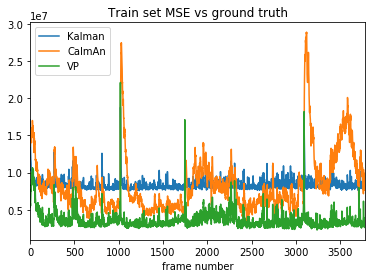

In [74]:
# plt.plot(result[:,0])
plt.xlim(0,n_samples-2)
plt.plot(result[:n_samples-2,1])
plt.plot(result[:n_samples-2,2])
plt.plot(result[:n_samples-2,3])
# TODO why a noise spike??
plt.xlim(0,n_samples-2)
# plt.ylim(5e5,2e6)
plt.legend(["Kalman", "CaImAn", "VP"])
plt.xlabel("frame number")
if use_test:
    tit = "Test"
else:
    tit = "Train"
plt.title(f"{tit} set MSE vs ground truth")

In [75]:
print("VP %noise of Kalman")
result[:,3].mean()/(result[:,1].mean())*100

VP %noise of Kalman


42.38865457147361

In [76]:
print("VP %noise of CaImAn")
result[:,3].mean()/(result[:,2].mean())*100

VP %noise of CaImAn


41.878141024189475

In [77]:
print("VP %noise of noisy imaging")
result[:,2].mean()/(result[:,0].mean())*100

VP %noise of noisy imaging


12.907443185303055